This code builds on Maria's deep learning model and 
- addresses data loading providing relative path to the processed data (by Niccolo)
- removes "/255" preprocessing step
- adds train/val split
- reduces layers
- adds disease-specific accuracies (test set)
- adds a section on new symptom set and a shortlist of 5 top predicted diseases 


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [2]:
import pandas as pd

# Load dataset
disease_df_train = pd.read_csv('../data/processed/Training.csv')

# Display dataset
disease_df_train.head(2)

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection


In [3]:
X_train = disease_df_train.drop(columns=['prognosis'])
y_train = disease_df_train['prognosis']
disease_df_test = pd.read_csv('../data/processed/Testing.csv')
X_test = disease_df_test.drop(columns=['prognosis'])
y_test = disease_df_test['prognosis']

In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
label_encoder = LabelEncoder()

# Fit and transform the prognosis labels into integers
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Convert the labels to one-hot encoded vectors
y_train = to_categorical(y_train, num_classes=41)  # 41 is the number of unique diseases
y_test = to_categorical(y_test, num_classes=41)

In [15]:
from sklearn.model_selection import train_test_split

# Further split the training data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

print(f"Training set size: {X_train_split.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 3936
Validation set size: 984
Test set size: 42


In [16]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.callbacks import EarlyStopping

# Sequential model
model = Sequential()

# Add layers
model.add(Dense(32, input_dim=X_train_split.shape[1], activation='relu'))  # Input layer + first hidden layer
model.add(Dropout(0.5))
model.add(Dense(41, activation='softmax'))  # Output layer (41 classes = diseases)

# Compile the model
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the validation set
history = model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    # callbacks=[early_stopping]
)

Epoch 1/10
123/123 [==============================] - 1s 4ms/step - loss: 3.6702 - accuracy: 0.0462 - val_loss: 3.5923 - val_accuracy: 0.1199
Epoch 2/10
123/123 [==============================] - 0s 2ms/step - loss: 3.5630 - accuracy: 0.0846 - val_loss: 3.4909 - val_accuracy: 0.1941
Epoch 3/10
123/123 [==============================] - 0s 2ms/step - loss: 3.4623 - accuracy: 0.1441 - val_loss: 3.3870 - val_accuracy: 0.3283
Epoch 4/10
123/123 [==============================] - 0s 2ms/step - loss: 3.3517 - accuracy: 0.2157 - val_loss: 3.2767 - val_accuracy: 0.4959
Epoch 5/10
123/123 [==============================] - 0s 2ms/step - loss: 3.2556 - accuracy: 0.2630 - val_loss: 3.1603 - val_accuracy: 0.5732
Epoch 6/10
123/123 [==============================] - 0s 3ms/step - loss: 3.1474 - accuracy: 0.3061 - val_loss: 3.0378 - val_accuracy: 0.6829
Epoch 7/10
123/123 [==============================] - 0s 3ms/step - loss: 3.0308 - accuracy: 0.3468 - val_loss: 2.9102 - val_accuracy: 0.7276
Epoch 

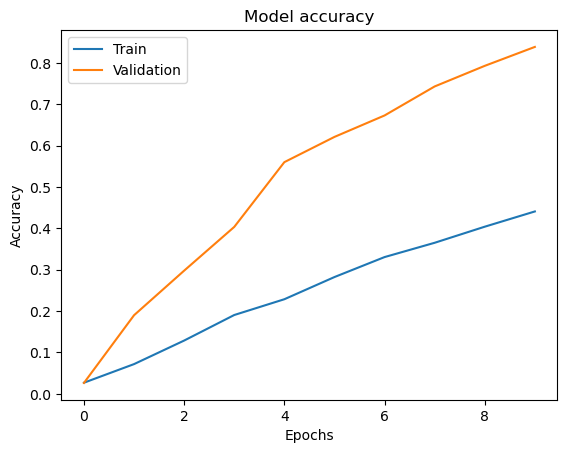

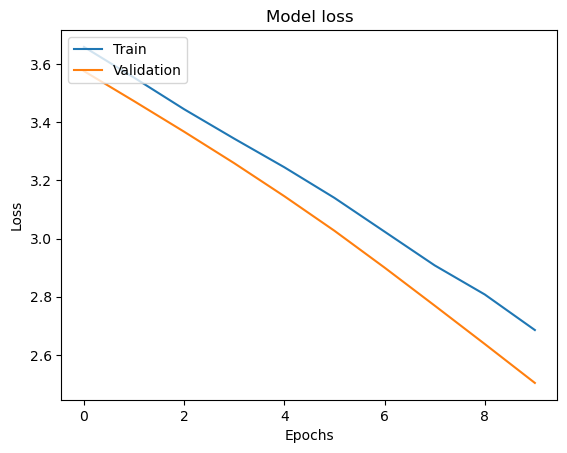

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [11]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss: .4f}")
print(f"Test Accuracy: {test_accuracy: .4f}")

2/2 [==============================] - 0s 4ms/step - loss: 2.4672 - accuracy: 0.8571
Test Loss:  2.4672
Test Accuracy:  0.8571


In [14]:
disease_list = label_encoder.classes_.tolist()
# Ensure predictions are probabilities for all test samples
predictions = model.predict(X_test)

# Convert one-hot encoded labels to class indices
true_labels = np.argmax(y_test, axis=1)  # Shape: (num_samples,)

# Loop over each disease
for disease_idx, disease in enumerate(disease_list):
    # Get indices of samples belonging to the current disease
    disease_indices = np.where(true_labels == disease_idx)[0]

    # Check if there are samples for the current disease
    if len(disease_indices) == 0:
        print(f"No samples for disease {disease}. Skipping...")
        continue

    # Extract predictions and compute accuracy for the current disease
    disease_predictions = np.argmax(predictions[disease_indices], axis=1)
    accuracy = np.mean(disease_predictions == disease_idx)

    print(f"Accuracy for {disease}: {accuracy:.2f}")

2/2 [==============================] - 0s 4ms/step
Accuracy for (vertigo) Paroymsal  Positional Vertigo: 1.00
Accuracy for AIDS: 1.00
Accuracy for Acne: 1.00
Accuracy for Alcoholic hepatitis: 1.00
Accuracy for Allergy: 0.00
Accuracy for Arthritis: 1.00
Accuracy for Bronchial Asthma: 0.00
Accuracy for Cervical spondylosis: 1.00
Accuracy for Chicken pox: 1.00
Accuracy for Chronic cholestasis: 1.00
Accuracy for Common Cold: 1.00
Accuracy for Dengue: 1.00
Accuracy for Diabetes : 1.00
Accuracy for Dimorphic hemmorhoids(piles): 1.00
Accuracy for Drug Reaction: 1.00
Accuracy for Fungal infection: 0.50
Accuracy for GERD: 0.00
Accuracy for Gastroenteritis: 0.00
Accuracy for Heart attack: 1.00
Accuracy for Hepatitis B: 1.00
Accuracy for Hepatitis C: 1.00
Accuracy for Hepatitis D: 0.00
Accuracy for Hepatitis E: 1.00
Accuracy for Hypertension : 1.00
Accuracy for Hyperthyroidism: 1.00
Accuracy for Hypoglycemia: 1.00
Accuracy for Hypothyroidism: 1.00
Accuracy for Impetigo: 1.00
Accuracy for Jaundice

Creating and testing a new symptom set

In [19]:
import pandas as pd

def construct_symptom_array(all_symptoms, active_symptoms):
    """
    Constructs a binary array representing symptom presence for a single patient.
    
    Parameters:
    - all_symptoms (list): A list of all possible symptoms (feature names of the model).
    - active_symptoms (list): A list of symptoms reported for the patient.
    
    Returns:
    - np.array: A binary array of length len(all_symptoms).
    """
    # Create a set for faster lookup
    active_symptoms_set = set(active_symptoms)
    
    # Create the binary array
    symptom_array = np.array([1 if symptom in active_symptoms_set else 0 for symptom in all_symptoms])
    
    return symptom_array

In [20]:
# Assume all_symptoms comes from your training data
all_symptoms = X_train.columns.tolist()  # List of all symptoms (feature names)
active_symptoms = ["inflammatory_nails", "blister", "small_dents_in_nails", "yellow_crust_ooze", "continuous_sneezing"]  # Example input symptoms from a user

# Construct the binary array
new_symptom_set = construct_symptom_array(all_symptoms, active_symptoms)

# Ensure the input is in the correct shape for the model
new_symptom_set = np.expand_dims(new_symptom_set, axis=0)  # Shape becomes (1, len(all_symptoms))

# Now it can be fed into the model for prediction
predictions = model.predict(new_symptom_set)

1/1 [==============================] - 0s 58ms/step


In [23]:
# Extract the mapping from the label encoder
disease_list = label_encoder.classes_.tolist()

# Get predictions for the input
predictions = model.predict(new_symptom_set)

# Extract the top 5 disease indices and probabilities
top_5_indices = predictions[0].argsort()[-5:][::-1]  # Indices of the top 5 predictions
top_5_probabilities = predictions[0][top_5_indices]  # Corresponding probabilities

# Map indices to disease names (if you have a label mapping)
disease_mapping = {i: disease_name for i, disease_name in enumerate(disease_list)}  # Example mapping
top_5_diseases = [disease_mapping[idx] for idx in top_5_indices]

# Print the results
for disease, prob in zip(top_5_diseases, top_5_probabilities):
    print(f"Disease: {disease}, Probability: {prob:.2f}")

1/1 [==============================] - 0s 20ms/step
Disease: Psoriasis, Probability: 0.05
Disease: Hypothyroidism, Probability: 0.04
Disease: Hypertension , Probability: 0.04
Disease: Dimorphic hemmorhoids(piles), Probability: 0.03
Disease: Common Cold, Probability: 0.03
